This script illustrates how to train a 2D U-Net on a labeled 3D EM volume. 

We will start by loading in the required modules and configuring the environment. 

In [1]:
# configure environment
import sys
sys.path.append('/home/jorisro/research/neuralnets')  # adjust this if necessary! This should point to the neuralnets repository

# dependencies
import argparse
import numpy as np
import yaml
import os
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from multiprocessing import freeze_support
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint

from neuralnets.data.datasets import LabeledVolumeDataset, LabeledSlidingWindowDataset
from neuralnets.networks.unet import UNet2D
from neuralnets.util.io import print_frm, rmdir, cp
from neuralnets.util.tools import set_seed, parse_params, get_transforms
from neuralnets.util.losses import get_loss_function
from neuralnets.util.validation import validate

Training a segmentation model requires quite some parameters to be set. These parameters can be bundled in a configuration YAML file. The following code loads and parses these parameters. 

In [2]:
param_config_file = 'train.yaml'  # adjust this path/file if necessary! 
with open(param_config_file) as file:
    params = parse_params(yaml.load(file, Loader=yaml.FullLoader))

If trained from scratch, U-Nets are usually initialized with random parameters. Consequently, subsequent runs will not necessarily result in the same result. To make sure that training is reproducible, you can fix a seed. 

In [3]:
set_seed(params['seed'])

We will now load the datasets and take care of data augmentation. The data is loaded in a PyTorch Dataset, sampling and batching can be automatically performed using PyTorch DataLoader wrappers. There are different types of datasets supported. Usually, a LabeledVolumeDataset is used: this will randomly select samples from the whole volume during training. In some situations however, a sliding window type of sampling is prefered (e.g. during testing). This is supported in a LabeledSlidingWindowDataset. Note that these datasets support unlabeled pixels, these should have intensity value 255 and will be ignored during training/testing. You can also provide a list of datasets, for this you should check out the documentation. 

Ideally, you want to keep track of the training progress with a training and validation dataset (e.g. to check overfitting), and measure the final performance on a separate test set. This means, the data should be split in three parts: train, validation and test. This splitting happens during initialization of the Dataset. Note that the augmentation transform is solely provided to the training dataset. 

In [4]:
# input shape as a 3-tuple (e.g. (1, 256, 256))
input_shape = (1, *(params['input_size']))  

# 2-tuple that indicates how to split the volume (e.g. 0.50, 0.75) will use 50% for training, 25% for validation and 25% for testing)
split = params['train_val_test_split']  

# obtain the transform that will perform data augmentation
transform = get_transforms(params['augmentation'], coi=params['coi'])
print_frm('Applying data augmentation! Specifically %s' % str(params['augmentation']))

# extract the train, validation and test datasets (the data will be loaded at this moment)
print_frm('Loading data')
train = LabeledVolumeDataset(params['data'], params['labels'], input_shape=input_shape,
                             in_channels=params['in_channels'], type=params['type'], len_epoch=params['len_epoch'],
                             batch_size=params['train_batch_size'], transform=transform, range_split=(0, split[0]),
                             range_dir=params['split_orientation'], coi=params['coi'])
val = LabeledSlidingWindowDataset(params['data'], params['labels'], input_shape=input_shape,
                                  in_channels=params['in_channels'], type=params['type'],
                                  batch_size=params['test_batch_size'], range_split=(split[0], split[1]),
                                  range_dir=params['split_orientation'], coi=params['coi'])
test = LabeledSlidingWindowDataset(params['data'], params['labels'], input_shape=input_shape,
                                   in_channels=params['in_channels'], type=params['type'],
                                   batch_size=params['test_batch_size'], range_split=(split[1], 1),
                                   range_dir=params['split_orientation'], coi=params['coi'])
train_loader = DataLoader(train, batch_size=params['train_batch_size'], num_workers=params['num_workers'],
                          pin_memory=True)
val_loader = DataLoader(val, batch_size=params['test_batch_size'], num_workers=params['num_workers'],
                        pin_memory=True)
test_loader = DataLoader(test, batch_size=params['test_batch_size'], num_workers=params['num_workers'],
                         pin_memory=True)

# show a few statistics of the data
print_frm('Label distribution: ')
for d in range(len(train.label_stats)):
    print_frm('  Dataset %s' % (params['data'] if type(params['data']) == str else params['data'][d]))
    for i in range(len(params['coi'])):
        print_frm('    - Class %d: %.3f (train) - %.3f (val) - %.3f (test)' %
                  (train.label_stats[d][i][0], train.label_stats[d][i][1],
                   val.label_stats[d][i][1], test.label_stats[d][i][1]))
    print_frm('    - Unlabeled pixels: %.3f (train) - %.3f (val) - %.3f (test)' %
              (train.label_stats[d][-1][1], val.label_stats[d][-1][1], test.label_stats[d][-1][1]))

[2022-05-23 12:58:12.832301] Applying data augmentation! Specifically ['rot90', 'flipx', 'flipy', 'contrast', 'noise']
[2022-05-23 12:58:12.833110] Loading data
[2022-05-23 12:58:22.003438] Label distribution: 
[2022-05-23 12:58:22.003925]   Dataset /home/jorisro/research/data/EM/EPFL/raw
[2022-05-23 12:58:22.004577]     - Class 0: 0.944 (train) - 0.938 (val) - 0.956 (test)
[2022-05-23 12:58:22.004835]     - Class 1: 0.056 (train) - 0.062 (val) - 0.044 (test)
[2022-05-23 12:58:22.005101]     - Unlabeled pixels: 0.000 (train) - 0.000 (val) - 0.000 (test)


As an illustration, we can show a randomly selected sample from the training data. 

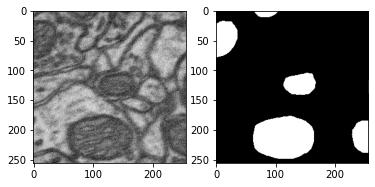

In [5]:
x, y = train[np.random.randint(len(train))]
plt.subplot(1, 2, 1)
plt.imshow(x[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(y[0], cmap='gray')
plt.show()

Now that we have data, it's time to intialize the model! 

In [6]:
print_frm('Building the network')
net = UNet2D(in_channels=params['in_channels'], feature_maps=params['fm'], levels=params['levels'],
             dropout_enc=params['dropout'], dropout_dec=params['dropout'], norm=params['norm'],
             activation=params['activation'], coi=params['coi'], loss_fn=params['loss'])

# note: if you want to finetune a model, you can load the pretrained weights using this line (ckpt_file points to the weights)
# net.load_state_dict(torch.load(ckpt_file)['state_dict'])

# uncomment the line below if you want to see the architecture of the model. 
# print(net)

[2022-05-23 12:58:22.223126] Building the network


We can now start training the model. To do this, we will employ the PyTorch Lighting library, which allows to efficiently train in a distributed manner. Simply construct a trainer object with all its required parameters (number of training epochs, GPU ids, logging directory, etc.) and start training! This is the time-consuming part where you really need a GPU. For simplicity, we only train for a few epochs, but it is advised to increase that number if you are going to train a model on new data. After each epoch, the model will be evaluated on the validation set, and we will keep track of progress. Finally, the best model will be saved and can be used, e.g. on new datasets. 

In [7]:
print_frm('Starting training')
print_frm('Training with loss: %s' % get_loss_function(params['loss']))
checkpoint_callback = ModelCheckpoint(save_top_k=1, verbose=True, monitor='val/mIoU', mode='max')
trainer = pl.Trainer(max_epochs=params['epochs'], gpus=params['gpus'], accelerator=params['accelerator'],
                     default_root_dir=params['log_dir'], flush_logs_every_n_steps=params['log_freq'],
                     log_every_n_steps=params['log_freq'], callbacks=[checkpoint_callback],
                     progress_bar_refresh_rate=params['log_refresh_rate'])
trainer.fit(net, train_loader, val_loader)
print_frm('Saving best model')
cp(trainer.checkpoint_callback.best_model_path, os.path.join(params['log_dir'], 'best_model.ckpt'))

[2022-05-23 12:58:22.252379] Starting training
[2022-05-23 12:58:22.253791] Training with loss: Cross entropy


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0     
1 | encoder | UNetEncoder2D    | 1.2 M 
2 | decoder | UNetDecoder2D    | 763 K 
---------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.775     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 124: val/mIoU reached 0.53923 (best 0.53923), saving model to "unet_2d/lightning_logs/version_0/checkpoints/epoch=0-step=124-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 249: val/mIoU reached 0.67475 (best 0.67475), saving model to "unet_2d/lightning_logs/version_0/checkpoints/epoch=1-step=249-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 374: val/mIoU was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 499: val/mIoU reached 0.75749 (best 0.75749), saving model to "unet_2d/lightning_logs/version_0/checkpoints/epoch=3-step=499-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 624: val/mIoU reached 0.76576 (best 0.76576), saving model to "unet_2d/lightning_logs/version_0/checkpoints/epoch=4-step=624-v1.ckpt" as top 1


[2022-05-23 13:00:51.750797] Saving best model
[2022-05-23 13:00:51.751582] Copying unet_2d/lightning_logs/version_0/checkpoints/epoch=4-step=624-v1.ckpt -> unet_2d/best_model.ckpt


Congratulations! You've trained a 2D U-Net from scratch! Now it's time to test the best model on the test data and measure the performance. 

In [8]:
print_frm('Validating the network')

# load the best parameters
net.load_state_dict(torch.load(trainer.checkpoint_callback.best_model_path)['state_dict'])

# validate all datasets (here, there's only one)
for d in range(len(test.data)):
    print_frm('  Dataset %s' % (params['data'] if type(params['data']) == str else params['data'][d]))
    
    # validate the performance and write out the segmentation
    validate(net, test.data[d], test.get_original_labels()[d], params['input_size'], in_channels=params['in_channels'],
             classes_of_interest=params['coi'], batch_size=params['test_batch_size'],
             write_dir=os.path.join(params['log_dir'], 'test_segmentation_' + str(d)), track_progress=True,
             device=params['gpus'][0])

[2022-05-23 13:00:51.772028] Validating the network
[2022-05-23 13:00:51.833709]   Dataset /home/jorisro/research/data/EM/EPFL/raw


Progress z-axis:   0%|          | 0/83 [00:00<?, ?it/s]

[2022-05-23 13:01:26.304394] Making unet_2d/test_segmentation_0
[2022-05-23 13:01:33.595269] Validation performance for class 0: 
[2022-05-23 13:01:33.597766]     - Accuracy: 0.988868
[2022-05-23 13:01:33.598958]     - Balanced accuracy: 0.906027
[2022-05-23 13:01:33.600340]     - Precision: 0.991445
[2022-05-23 13:01:33.603671]     - Recall: 0.996952
[2022-05-23 13:01:33.604797]     - F1 score: 0.994191
[2022-05-23 13:01:33.605928]     - IoU: 0.988469
[2022-05-23 13:01:33.607135]     - Hausdorff distance: -1.000000
[2022-05-23 13:01:33.608349] Validation performance for class 1: 
[2022-05-23 13:01:33.609421]     - Accuracy: 0.988868
[2022-05-23 13:01:33.610513]     - Balanced accuracy: 0.906027
[2022-05-23 13:01:33.611679]     - Precision: 0.925613
[2022-05-23 13:01:33.612747]     - Recall: 0.815102
[2022-05-23 13:01:33.613819]     - F1 score: 0.866849
[2022-05-23 13:01:33.614976]     - IoU: 0.765074
[2022-05-23 13:01:33.616021]     - Hausdorff distance: -1.000000
[2022-05-23 13:01:33